In [1]:
using ForwardDiff
import ForwardDiff.derivative
using NLsolve

In [2]:
type Boundary
    shape::Function
    tangent::Function
    normal::Function
end

In [3]:
#using Plots
#pyplot(leg=false, size=(500,300))
#n = 10
#y = rand(n)
#vx, vy = randn(n), randn(n)
#quiver(y, quiver=(vx,vy))

In [4]:
normal

LoadError: LoadError: UndefVarError: normal not defined
while loading In[4], in expression starting on line 1

In [5]:
sineboundary = Boundary(boundary, tangent, normal)

LoadError: LoadError: UndefVarError: boundary not defined
while loading In[5], in expression starting on line 1

In [6]:
sin(6)

-0.27941549819892586

In [7]:
sineboundary.shape(2; s=3.)

LoadError: LoadError: UndefVarError: sineboundary not defined
while loading In[7], in expression starting on line 1

In [8]:
sineboundary.tangent(sineboundary.shape,2.)

LoadError: LoadError: UndefVarError: sineboundary not defined
while loading In[8], in expression starting on line 1

In [9]:
function normal(b::Function, x)
    f = y -> derivative(b,y)
    normalization = (1 + f(x)^2)^(1/2)
    [f(x)/normalization, 1/normalization]
end

function tangent(b::Function, x)
    f = y -> derivative(b,y)
    normalization = (1 + f(x)^2)^(1/2)
    [-1/normalization, f(x)/normalization]
end



tangent (generic function with 1 method)

In [10]:
boundary(x; s = 1.0) = sin(s*x)

boundary (generic function with 1 method)

In [11]:
x = -4*pi:0.01:2*pi
n = [normal(boundary, i) for i in x]
t = [tangent(boundary, i) for i in x];

In [12]:
using PyPlot

In [13]:
plot(x,boundary(x),".-")
plot([-4,-2.],[-0.5,0.5],"o-")
plot(a,boundary(a),"ro")
plot(a,slop(a),"ro")
plot(x,slop(x))

LoadError: LoadError: UndefVarError: a not defined
while loading In[13], in expression starting on line 3

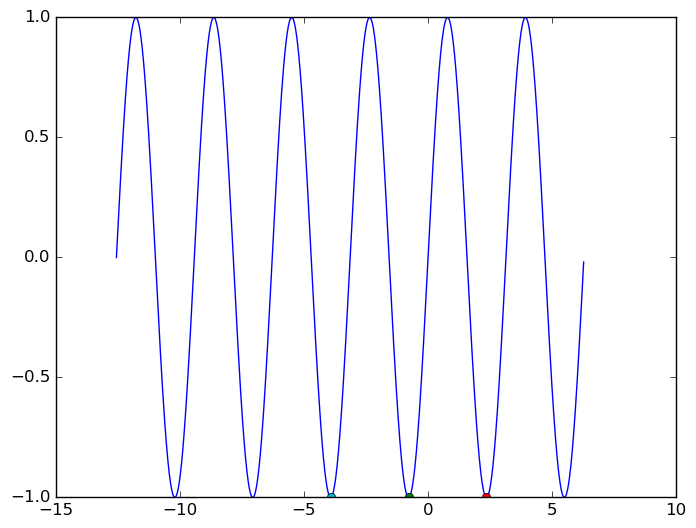

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd275791390>

In [14]:
plot(x,sin(2*x))
plot(-pi/4,sin(2*(-pi/4)),"o")
plot(3*pi/4,sin(2*(3*pi/4)),"o")
plot(-pi/4-pi,sin(2*(-pi/4)),"o")

In [15]:
x1, y1 = [-4.,-0.5]
x2, y2 = [-2.,0.5];
m = (y2-y1)/(x2-x1)
slop(x) = m*(x-x2) + y2

slop (generic function with 1 method)

In [16]:
function f!(x)
    m = (y2-y1)/(x2-x1)
    boundary(x)-slop(x)
end

f! (generic function with 1 method)

In [17]:
using Roots

In [18]:
a = fzero(f!,x1)
sin(a)

-0.04719170652463839

In [19]:
a, slop(a)

(-3.094383413049278,-0.047191706524639)

In [20]:
boundary(a)

-0.04719170652463839

In [21]:
slop(a)

-0.047191706524639

In [22]:
type Particle{T}
    r::Array{T,1}  #[x, y]
    rprevious::Array{T,1} #[x,y]
end

In [23]:
sig = 2
a = 2*pi/(2*sig)
b = a + 2*pi/(sig)
c = b - 3*pi/(2*sig)
Int(div(c, (2*pi/sig)) + 1)
k = -5.
Int(div(k + pi/(2*sig), (2*pi/sig)) -1)

-2

In [40]:
function previouscelda(p :: Particle; lambda = 0.8, sigma = 0.1)

            if -pi/(2*sigma) < p.rprevious[1] < 3*pi/(2*sigma)
                prevcelda = 0
            elseif p.rprevious[1] > 3*pi/(2*sigma)
                a = p.rprevious[1] - 3*pi/(2*sigma)
                prevcelda = div(c,(2*pi/sig)) + 1
            else
                a = p.rprevious[1] + pi/(2*sigma)
                prevcelda = Int(div(k + pi/(2*sig), (2*pi/sig)) -1)
            end
    
    prevcelda
end

previouscelda (generic function with 1 method)

In [39]:
function currentcelda(p :: Particle; lambda = 0.8, sigma = 0.1)

            if -pi/(2*sigma) < p.r[1] < 3*pi/(2*sigma)
                celda = 0
            elseif p.r[1] > 3*pi/(2*sigma)
                a = p.r[1] - 3*pi/(2*sigma)
                celda = div(c,(2*pi/sig)) + 1
            else
                a = p.r[1] + pi/(2*sigma)
                celda = Int(div(k + pi/(2*sig), (2*pi/sig)) -1)
            end
    
    celda
end

currentcelda (generic function with 1 method)

In [41]:
function incell(p::Particle, sigma)
    if p.r[2] < boundary(p.r[1], s=sigma)
        return true
    else
        return false
    end
end
        

incell (generic function with 1 method)

In [56]:
function straightlineparticle(p::Particle)
    f(x) = (p.r[2] - p.rprevious[2])/(p.r[1] - p.rprevious[1])*(x - p.r[1]) + p.r[2]
end
    

straightlineparticle (generic function with 1 method)

In [57]:
function reflectingboundaries(boundary::Function, p::Particle)
    intersection = boundary - straightlineparticle(p)
    xint = fzero(intersection,p.r[1])
    yint = boundary(xint)
    rint = p.r - [xint, yint]
    tanvector = dot(rint, tangent(boundary,xint))*tangent(boundary,xint)
    norvector = -dot(rint, normal(boundary,xint))*normal(boundary,xint)
    p.r = [xint, yint] + tanvector + norvector
end

reflectingboundaries (generic function with 1 method)

In [49]:
function boundarysine(p :: Particle; lambda = 0.1, sigma = 1.0)
    
    if p.rprevious[2] > 1. - lambda
        prevcelda = previouscelda(p)
    end
    
    if p.r[2] > 1. - lambda
        currcelda = currentcelda(p)
        if  incell(p, sigma)
            if abs(currcelda - prevcelda) >= 1
                error("Movimiento no permitido")
            end
        else
            reflectingboundaries(boundary, particle)
               
    end
    
    
    
end
        
        


boundarysine (generic function with 1 method)

In [50]:
nsteps = 100
nsampling = 10
positions = zeros(nsteps,2)
temporary = zeros(nsampling,2);

In [51]:
p = Particle([0.,0.], [0.,0.])

Particle{Float64}([0.0,0.0],[0.0,0.0])

In [52]:
dt = 1e-4
Dx = Dy = 1.

1.0

In [53]:
for i in 2:nsteps
    for k in 1:nsampling
        if k ==1
            p.rprevious =   positions[i-1,:]
            temporary[k,:] = p.rprevious
        else
            p.rprevious =   temporary[k-1,:]
        end
         p.r += sqrt(2*dt)*[Dx*randn(), Dy*randn()]
        boundarysine(p)
         temporary[k,:] = p.r
        end
        positions[i,:,] = p.r 
end

In [54]:
positions

100×2 Array{Float64,2}:
  0.0         0.0      
 -0.00759933  0.0711927
 -0.0354602   0.0988515
 -0.0139461   0.0935854
 -0.0361091   0.159906 
 -0.061158    0.136191 
 -0.0642318   0.111466 
 -0.00921067  0.153266 
 -0.0619818   0.210292 
 -0.0724133   0.205036 
 -0.00118544  0.154215 
  0.0203958   0.158939 
  0.0805626   0.216694 
  ⋮                    
 -0.283225    0.794368 
 -0.235694    0.762892 
 -0.178937    0.760257 
 -0.324468    0.740338 
 -0.350806    0.80139  
 -0.403597    0.856337 
 -0.437746    0.817471 
 -0.446351    0.817444 
 -0.492361    0.783419 
 -0.484204    0.720423 
 -0.469263    0.717343 
 -0.481753    0.758873 

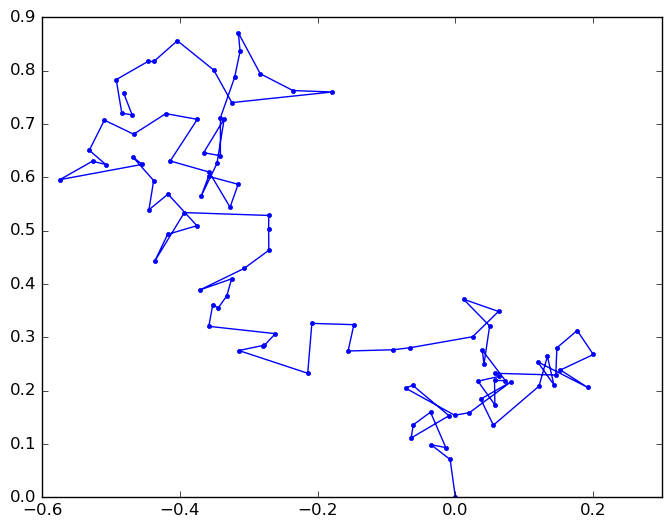

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd2754fdc90>

In [55]:
plot(positions[:,1], positions[:,2],".-")